# Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Run Codes Locally on Your Machine**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.

# Strategy Analytics
In the previous notebook, you have learned to compute trade-level analytics on the trades generated over the backtest period. In this notebook, you will learn to understand the overall performance of the strategy with the help of plots and performance metrics. 

The notebook is structured as follows:
1. [Read the Data](#read)
2. [Strategy Returns](#returns)
3. [Cumulative Returns vs Underlying Plot](#plot-1)
4. [Profit and Loss Analysis](#pla)
5. [Maximum Drawdown](#mdd)<br>
   5.1. [Plot Maximum Drawdown](#mddplot) <br>
6. [CAGR](#cagr)
7. [Annualised Volatility](#vol)
8. [Sharpe Ratio](#sharpe)

## Import Libraries

In [1]:
# For Data manipulation
import pandas as pd
import numpy as np
import datetime as datetime

# For plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

<a id='read'></a>
## Read the Data

In the previous section, the list of strategies were backtested from 2020 to 2022 and the round trips were generated. Import the trades data, round trips data, the mark-to-market data and underlying data from `trades_LSTM_mlo.csv`, `round_trips_lstm_mlo.csv`, `mark_to_market_lstm_mlo.csv`,  `underlying_data_model_mlo.csv` in the `data_modules` folder. 

In [2]:
# Import round trip details and mark to market data
round_trips = pd.read_csv('../data_modules/round_trips_lstm_mlo.csv', index_col=0)
round_trips.index = round_trips.entry_date
round_trips.index.name = 'date'
mtm = pd.read_csv('../data_modules/mark_to_market_lstm_mlo.csv', index_col=0)
trades = pd.read_csv('../data_modules/trades_lstm_mlo.csv', index_col=0)

# Import the underlying data with option chain data and target variable
underlying_data = pd.read_csv(
    '../data_modules/underlying_data_model_mlo.csv', index_col='quote_date')
trades.head()

,entry_date,Entry_Date,Exit_Date,Exit_Type,PnL,Turnover,PnL_post_trading_costs_slippages,holding_period
0,2020-10-08,2020-10-08,2020-10-09,Expiry or Signal Based,-3118.0,26388.0,-3118.0,1 days
1,2020-10-09,2020-10-09,2020-10-12,SL,-4581.0,16081.0,-4581.0,3 days
2,2020-10-13,2020-10-13,2020-10-14,Expiry or Signal Based,1095.0,10959.0,1095.0,1 days
3,2020-10-14,2020-10-14,2020-10-15,Expiry or Signal Based,-1198.0,22880.0,-1198.0,1 days
4,2020-10-15,2020-10-15,2020-10-16,Expiry or Signal Based,550.0,11190.0,550.0,1 days


<a id='returns'></a>
## Strategy Returns

To calculate the returns, we need to calculate the capital required to take each trade.

* For buying an option, the capital required is a multiple of the premium and the lot size.

 <img src="https://d2a032ejo53cab.cloudfront.net/Glossary/1qWgNIVS/margin-buy.png" width="400">
 
 
 * For selling an option, the capital required is the margin decided by the broker and the exchange. The total margin required to sell an option is the sum of SPAN and exposure margins. The option sellers have to maintain the total margin in their trading account to cover potential losses.

 <img src="https://d2a032ejo53cab.cloudfront.net/Glossary/aBZVHHAY/margin.png" width="400">
 
 
* We assume the span margin to be 10% of the notional value (notional value = strike price * lot size)
* The exposure margin is 6% of the notional value.

* The span margin depends on the volatility of underlying and varies over the day as per volatility. The margin will increase substantially during highly volatile phases of the market. So, to account for this, we will add 3% of the notional value to the total margin. 

* The SPAN® (Standard Portfolio Analysis of Risk) margin is calculated by the exchanges using various parameters such as interest rates, strike price, change in price and volatility of the underlying etc. The SPAN margin calculates the potential risk of holding the position for one day.
* The exposure margin is charged by the broker to cover the risk in case of unusual movements in the market.
<!-- * Netting benefits are applicable for a limited risk strategy which significantly reduces the capital requirement. As the butterfly strategy is a limited risk strategy we have assumed a netting benefit of 70%. -->

In [3]:
# Assume lot size as 100
lot_size = 100

# Calculate net premium
mtm['net_premium'] = mtm.position * mtm.premium * lot_size

# Initialise a column to store margin
mtm["margin"] = np.nan

# Capital required for option buying
capital_option_buying = mtm['premium'] * lot_size

# Notional value
notional_value = mtm['Strike Price'] * lot_size

# Span margin for shorting option
span = (notional_value * 0.1)

# Exposure margin for shorting option
exposure = (notional_value * 0.06)

# Adding 3% of notional value to the margin
margin_option_selling = span + exposure + (0.03 * notional_value)

# Calculate capital required for buy positions
mtm["margin"] = np.where((mtm['position'] == 1) & (mtm['Option Type'] != 'stock'),
                         capital_option_buying, mtm['margin'])

# Calculate margin required for sell positions
mtm["margin"] = np.where((mtm['position'] == -1) & (mtm['Option Type'] != 'stock'),
                         margin_option_selling, mtm['margin'])

# Calculate margin required for sell positions
mtm["margin"] = np.where((mtm['position'] == -1) & (mtm['Option Type'] != 'stock'),
                         margin_option_selling, mtm['margin'])

# Calculate margin required for taking position in underlying
mtm["margin"] = np.where(mtm['Option Type'] == 'underlying',
                         abs(mtm['net_premium']), mtm['margin'])

mtm.head()

,Option Type,Strike Price,position,premium,Date,net_premium,margin
0,call,3445.0,-1,66.45,2020-10-08,-6645.0,65455.0
1,put,3445.0,1,70.09,2020-10-08,7009.0,7009.0
2,underlying,3445.0,-1,0.00,2020-10-08,-0.0,0.0
0,call,3445.0,-1,77.44,2020-10-09,-7744.0,65455.0
1,put,3445.0,1,49.90,2020-10-09,4990.0,4990.0


In [4]:
# Profit and Loss of trades
round_trips['pnl'] = round_trips['position'] * \
    (round_trips['exit_price']-round_trips['entry_price'])

daily_pnl = round_trips.groupby('date').pnl.sum()
daily_capital = mtm.groupby('Date').margin.sum()

lot_size = 100
analytics = pd.DataFrame()
analytics['pnl'] = lot_size*round_trips.groupby('date').pnl.sum()
analytics['capital'] = daily_capital[[
    element for element in daily_capital.index if element in daily_pnl.index]]
analytics['returns'] = 100*analytics['pnl']/analytics['capital']

# Calculate daily margin and returns
daily_mtm = pd.DataFrame()
daily_mtm["margin"] = daily_capital[[
    element for element in daily_capital.index if element in daily_pnl.index]]
daily_mtm["daily_returns"] = analytics['pnl'] / daily_mtm["margin"]
daily_mtm.head()

,margin,daily_returns
Date,,
2020-10-08,72464.0,-0.043028
2020-10-09,136470.0,-0.033568
2020-10-13,66690.0,0.016419
2020-10-14,139162.0,-0.008609
2020-10-15,137743.0,0.003993


In [5]:
# Initialise a column to track returns
underlying_data['strategy_returns'] = np.nan

Iterate through each row of the `daily_mtm` dataframe and replace the NaN values in `strategy_returns` with `daily_returns`. Calculate the cumulative returns and store the same in `Cumulative_Returns`.

In [6]:
for index, row in daily_mtm.iterrows():
    underlying_data.at[index, 'strategy_returns'] = row['daily_returns']

# Replace nan values in 'strategy_returns' column of dataframe 'underlying' with '0'
underlying_data['strategy_returns'] = underlying_data['strategy_returns'] .fillna(0)

# Create the column 'Cumulative_Returns' in dataframe 'underlying' to store the cumulative returns
underlying_data['Cumulative_Returns'] = (
    underlying_data['strategy_returns'] + 1.0).cumprod()

# Print cumulative returns
underlying_data['Cumulative_Returns'].tail()

quote_date
2022-09-20    1.183776
2022-09-21    1.183776
2022-09-22    1.249150
2022-09-23    1.225817
2022-09-26    1.225817
Name: Cumulative_Returns, dtype: float64

<a id='plot-1'></a>
## Cumulative Returns vs Underlying Plot

Plot the cumulative returns over the close price of the underlying. This helps us to visually identify how major movements in the underlying impacted the performance of the strategy.

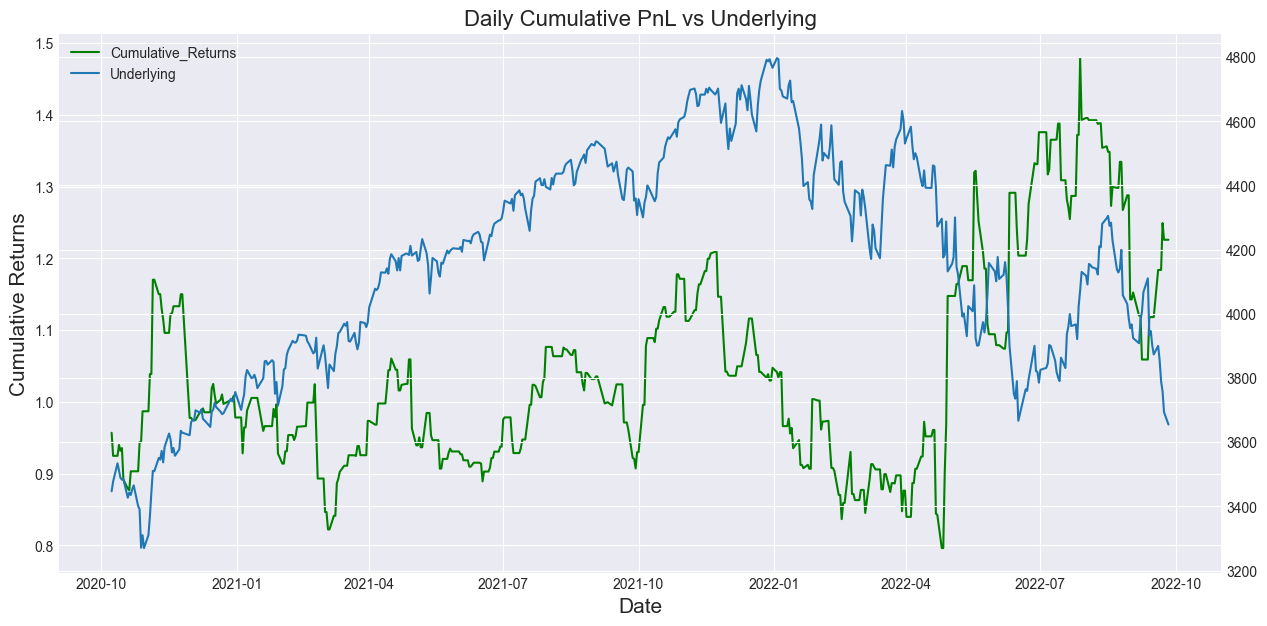

In [7]:
# Convert index of underlying and Entry_Date column of trades as datetime objects
underlying_data.index = pd.to_datetime(
    underlying_data.index, format='%Y-%m-%d')
trades['Entry_Date'] = pd.to_datetime(trades['Entry_Date'], format='%Y-%m-%d')

# Select underlying data on backtest period
underlying_data = underlying_data[trades.entry_date[0]:]

# Define the figure and subplot variables
fig, ax = plt.subplots(figsize=(15, 7))

# Plot the daily cumulative returns
plot_1, = ax.plot(underlying_data.index,
                  underlying_data['Cumulative_Returns'], color='g', label='Cumulative_Returns')

# Set x-axis label
ax.set_xlabel("Date", fontsize=15)

# Set y-axis label
ax.set_ylabel("Cumulative Returns", fontsize=15)

# Define a subplot with twin axis
ax2 = ax.twinx()

# Plot the close price of the underlying
plot_2, = ax2.plot(
    underlying_data.index, underlying_data['close'], label='Underlying')

# # Plot the markers to represent the trade entries
# ax2.plot(trades['Entry_Date'], underlying_data.loc[trades['Entry_Date']
#                                               ].close, '*', color='red', markersize=8)

# Define the title of the plot
plt.title('Daily Cumulative PnL vs Underlying', fontsize=16)

# Define legend for line plots and markers
plt.legend(handles=[plt.plot([], ls="-", color=plot_1.get_color())[0], plt.plot([], ls="-", color=plot_2.get_color())[0], plt.plot([], "*", color='red', markersize=12)[0]],
           labels=[plot_1.get_label(), plot_2.get_label()], loc='upper left')

# Show the plot
plt.show()

<a id='pla'></a>
## Profit and Loss Analysis

Create a heatmap of monthly profit and loss to understand the monthly performance of the LSTM based strategy generator.

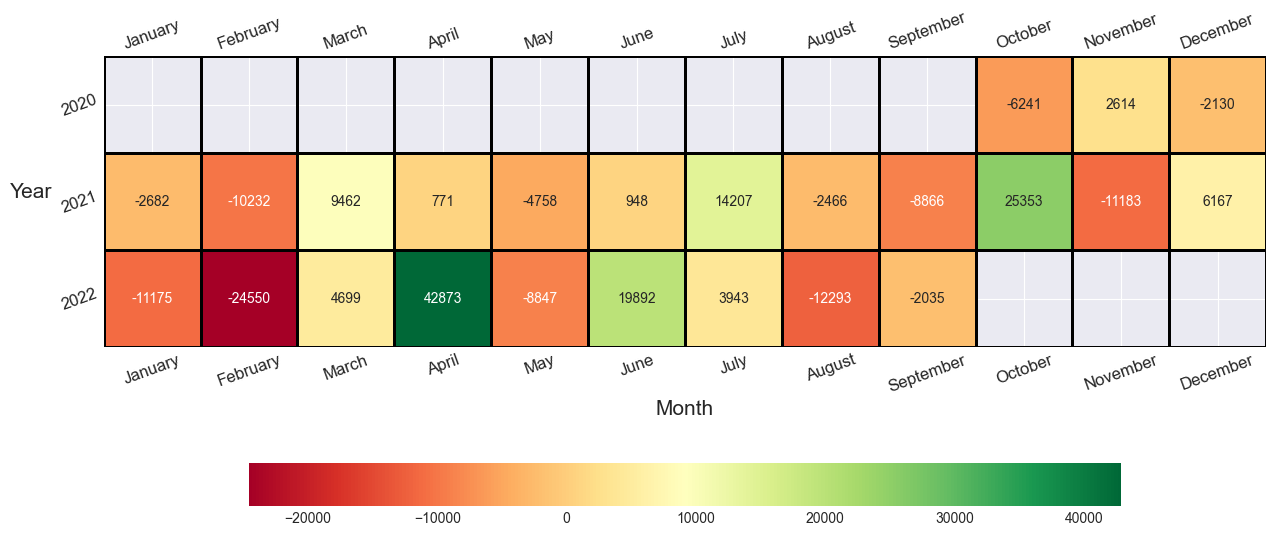

In [8]:
import seaborn as sns
# Create the dataframe 'trades_heatmap'
trades_heatmap = trades[['Entry_Date', 'PnL_post_trading_costs_slippages']]

# Set 'Entry_Date' as index of the dataframe 'trades_heatmap'
trades_heatmap.index = trades_heatmap.Entry_Date

# Store name of the month and year in the columns 'M' and 'Y' respectively
trades_heatmap['M'] = trades_heatmap.index.month_name()
trades_heatmap['Y'] = trades_heatmap.index.year

# Aggregate monthly PnL and store in 'trades_heatmap_monthly'
trades_heatmap_monthly = trades_heatmap.resample('M').agg(
    {'PnL_post_trading_costs_slippages': np.sum, 'M': lambda x: x.mode(), 'Y': np.mean}).dropna()
trades_heatmap_monthly.Y = trades_heatmap_monthly.Y.astype(int)

# Create a pivot table 'heatmap_ret' with the name of months as index
heatmap_ret = pd.pivot_table(
    trades_heatmap_monthly, index='Y', columns='M', values=['PnL_post_trading_costs_slippages'])
heatmap_ret = heatmap_ret.reindex(columns=heatmap_ret.columns.reindex(
    ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], level=1)[0])

# Define a figure to plot the heatmap of monthly PnL
plt.figure(figsize=(15, 10))

# Define a subplot to plot 'heatmap_ret'
ax = sns.heatmap(heatmap_ret, cmap='RdYlGn', annot=True, fmt='g', linewidths=1,
                 cbar=True, xticklabels=heatmap_ret.columns.get_level_values(1), linecolor='black', square=True, cbar_kws={"orientation": "horizontal", "shrink": 0.75})

# Set tick parameters of the heatmap
ax.tick_params(top=True, labeltop=True, labelrotation=20, labelsize=12)

# Set X and Y labels of the heatmap
ax.set_xlabel('Month', fontsize=15)
ax.set_ylabel('Year', fontsize=15, rotation=0, labelpad=20)

plt.show()

<a id='mdd'></a>
## Maximum Drawdown
Maximum drawdown is one of the key measures to assess the risk of a strategy.  In your trading strategy, your returns reduce in value multiple times. These reductions in value are known as drawdowns. The maximum of these drawdown values gives us an estimate of the maximum loss a strategy can incur. Technically, it is defined as the maximum loss from peak to trough of cumulative returns and is expressed in percentage terms. It can be calculated by the following formula: 

$$ Maximum ~Drawdown = \frac{Peak ~value - Trough ~value }{Peak ~value} $$

Generally, a lower magnitude of maximum drawdown is desired. 


In [9]:
# Compute the cumulative maximum
cumulative_max = underlying_data['Cumulative_Returns'].cummax()

# Calculate the drawdown in percentage
drawdown = pd.DataFrame(
    ((underlying_data.Cumulative_Returns)/cumulative_max - 1) * 100)
drawdown.columns = ['Drawdown']

# Print Maximum Drawdown
print(f'The maximum drawdown is', round(drawdown.min()[0], 2), '%')

# Number of days with maximum drawdown
max_drawdown_days = len(
    drawdown.loc[drawdown.Drawdown == drawdown.min().values[0]])

print(f'Number of days with maximum drawdown is', max_drawdown_days)

The maximum drawdown is -34.15 %
Number of days with maximum drawdown is 2


## <a id='mddplot'></a>
### Plot Maximum Drawdown

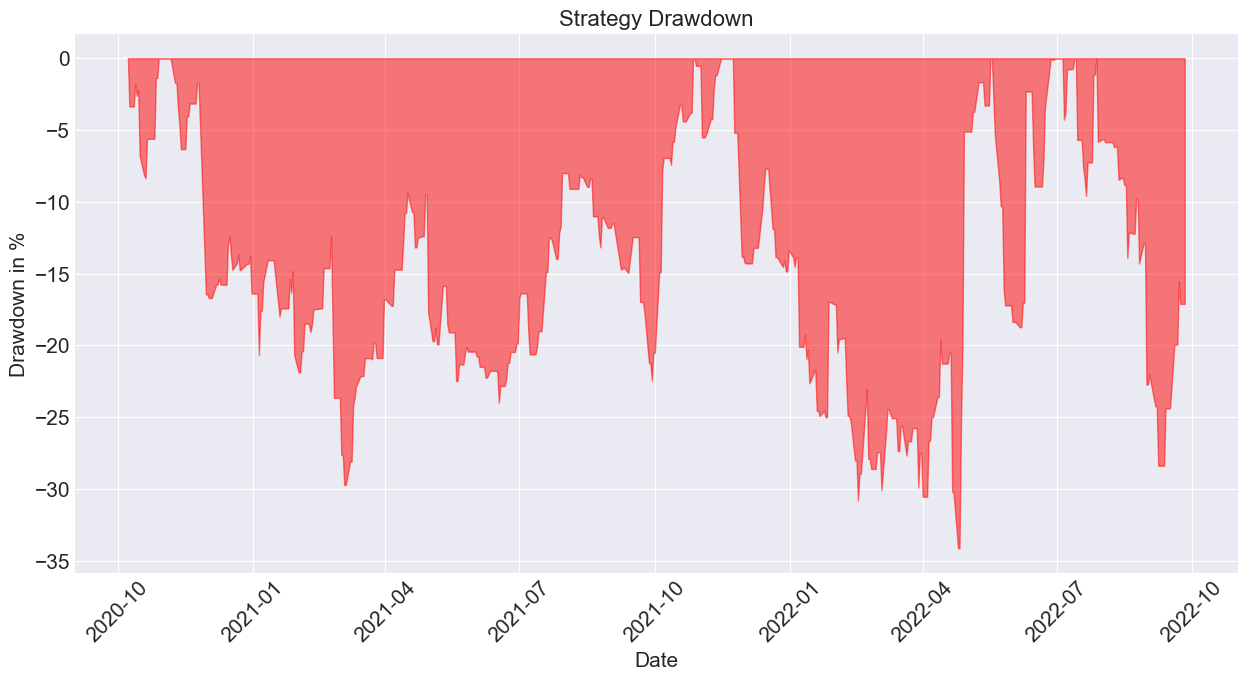

In [10]:
# Set the figure size
plt.figure(figsize=(15, 7))

# Set the title
plt.title('Strategy Drawdown', fontsize=16)

# Set the labels
plt.ylabel('Drawdown in %', fontsize=15)
plt.xlabel('Date', fontsize=15)

# Set the tick size
plt.tick_params(labelsize=15)
plt.xticks(rotation=45)

# Fill the space between 0 and the drawdown with red colour
plt.fill_between(drawdown.index, drawdown['Drawdown'], alpha=0.5, color='r')

# Show the graph
plt.show()

<a id='cagr'></a>
## CAGR
CAGR stands for compound annual growth rate. It is the measure of a strategy's annual growth rate over time, with the effect of compounding taken into account. It is calculated by the following formula: 

$$ CAGR = \left(\left(\frac{EV}{BV}\right)^{\frac{1}{n}} -1\right)*100 $$

where
* $EV$ is the ending value
* $BV$ is the beginning value
* $n$ is the number of years


In [11]:
# Total number of trading days
trading_days = len(underlying_data)

# Calculate compounded annual growth rate
CAGR = (underlying_data.Cumulative_Returns.iloc[-1]**(252/trading_days)-1)*100

print(f'The CAGR of the strategy is:', round(CAGR, 2), '%')

The CAGR of the strategy is: 11.18 %


<a id='vol'></a>
## Annualised Volatility
Volatility of returns is the rate at which strategy returns increase or decrease over a period of time. 

Calculate the daily volatility of returns by taking the standard deviation of the `strategy_returns`. Multiply it by the square root of 252 to get annualised volatility 

In [12]:
# Calculate annualised volatility
annualised_volatility = underlying_data['strategy_returns'].std()*np.sqrt(252)

print(f'The annualised volatility of returns is',
      round(annualised_volatility, 1), '%')

The annualised volatility of returns is 0.5 %


The strategy's annualised volatility works out to be 0.5%. This indicates that the returns for our strategy returns can fluctuate by 0.5% on an average in a year.
<a id='sharpe'></a>
## Sharpe Ratio

Sharpe ratio measures the performance of a strategy when compared to a risk-free rate. It is the ratio of the returns earned in excess of the risk-free rate to the volatility. 
It is calculated as below:
$$ Sharpe~ratio = \frac{R_x-R_f}{\sigma_x}$$

where
* $R_x$ is the mean return of the strategy
* $R_f$ is the risk-free rate
* $\sigma_x$ is the volatility

Sharpe ratios greater than 1 are preferable, as it means your returns are greater given the risk you are taking. Generally, a strategy with a higher Sharpe ratio will be preferred over a strategy with a lower Sharpe ratio.

In [13]:
# Set a risk-free rate
risk_free_rate = 0.02/252

# Calculate Sharpe ratio
sharpe_ratio = np.sqrt(252)*(np.mean(daily_mtm.daily_returns) -
                             (risk_free_rate))/np.std(daily_mtm.daily_returns)

print(f' The strategy has a Sharpe ratio of:', round(sharpe_ratio, 2))

 The strategy has a Sharpe ratio of: 0.56


## Conclusion
In this notebook, we have calculated several strategy metrics to understand the performance of the strategy. This strategy has generated moderate results but the metrics can be improved by tuning the ML model and improving the features and datasets. <br><br>